In [54]:
##Time Series Analysis

In [18]:
# Import all required libraries and models 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.rcParams['figure.figsize'] = (15, 8)

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf # plot partial autocorrelation function

In [19]:
#Read text file using pandas library  
df = pd.read_csv('Data\TG_STAID002759.txt',sep=',', index_col=1, parse_dates=True)
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [20]:
df.shape

(52992, 3)

In [21]:
df.info

<bound method DataFrame.info of              SOUID  TG  Q_TG
DATE                        
1876-01-01  127488  22     0
1876-01-02  127488  25     0
1876-01-03  127488   3     0
1876-01-04  127488 -58     0
1876-01-05  127488 -98     0
...            ...  ..   ...
2021-01-27  111448  19     0
2021-01-28  111448  16     0
2021-01-29  100133 -12     0
2021-01-30  100133 -12     0
2021-01-31  100133 -52     0

[52992 rows x 3 columns]>

In [22]:
df.dtypes

SOUID    int64
TG       int64
Q_TG     int64
dtype: object

In [23]:
#Checking for missing values in the data 
(df['TG'] == -9999).value_counts()
 # There are missing temperarture values for 195 days

False    52797
True       195
Name: TG, dtype: int64

In [24]:
#Replace the missing values with TG of another year
df['TG'] = df['TG'].replace(-9999, df.loc['1945-04-25':'1945-11-25', 'TG'].mean())

In [25]:
(df['TG'] == -9999).value_counts()

False    52992
Name: TG, dtype: int64

In [26]:
#The unit of the temperature is 0.1 °C in this dataset
df['TG'] = df['TG']*0.1
#Drop unnecessary columns
df = df.drop(columns=['SOUID','Q_TG'])

In [27]:
#Train-Test-Split
df_train = df['January 1960':'December 2010'].copy() 
df_test = df['Jan 2011':].copy()

In [28]:
df_train.shape, df_test.shape

((18628, 1), (3684, 1))

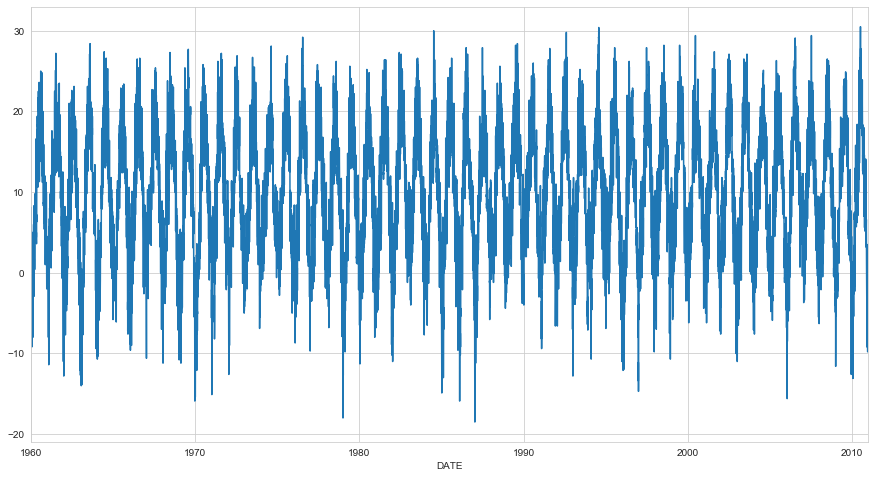

In [29]:
df_train['TG'].plot()

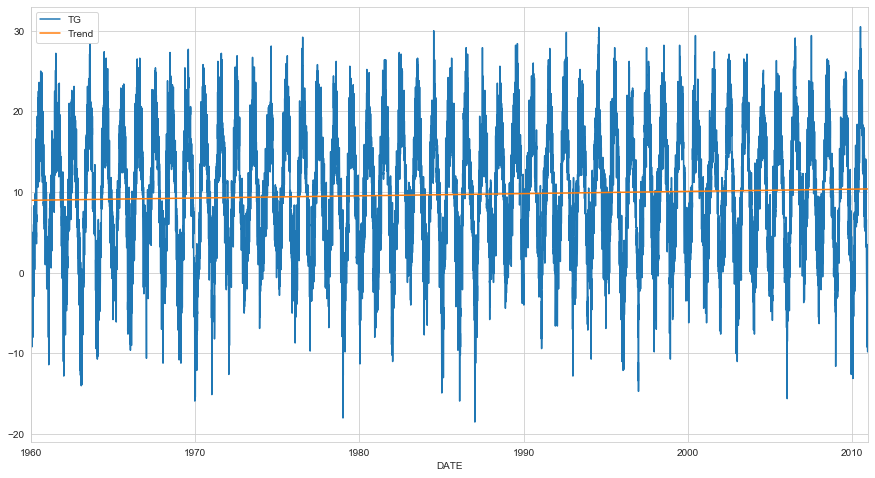

In [30]:
df_train['timestep'] = range(len(df_train))
X = df_train[['timestep']]
y = df_train['TG']
m = LinearRegression()
m.fit(X,y)
df_train['Trend'] = m.predict(X)
df_train[['TG', 'Trend']].plot()

In [ ]:
#df_train.groupby(df_train.index.month)['TG'].mean().plot()

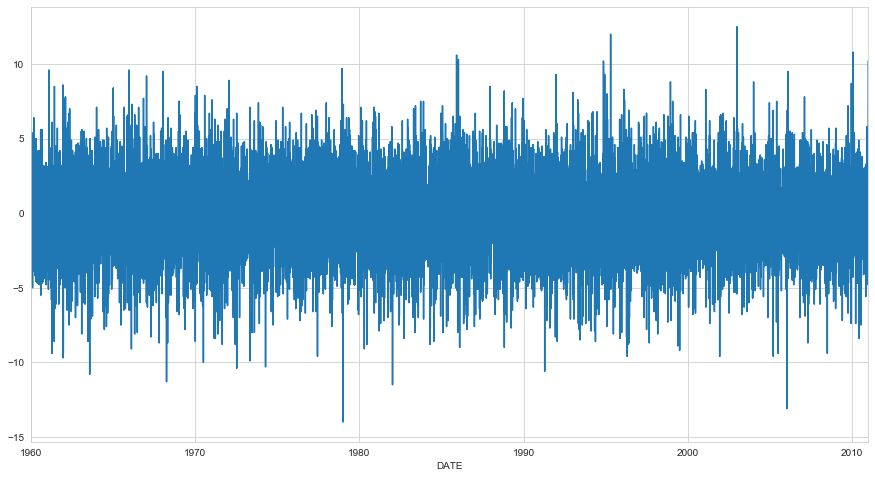

In [31]:
#we can plot the remainder by using diff() function where trend will be substracted from temperature
df_train['TG'].diff().plot()

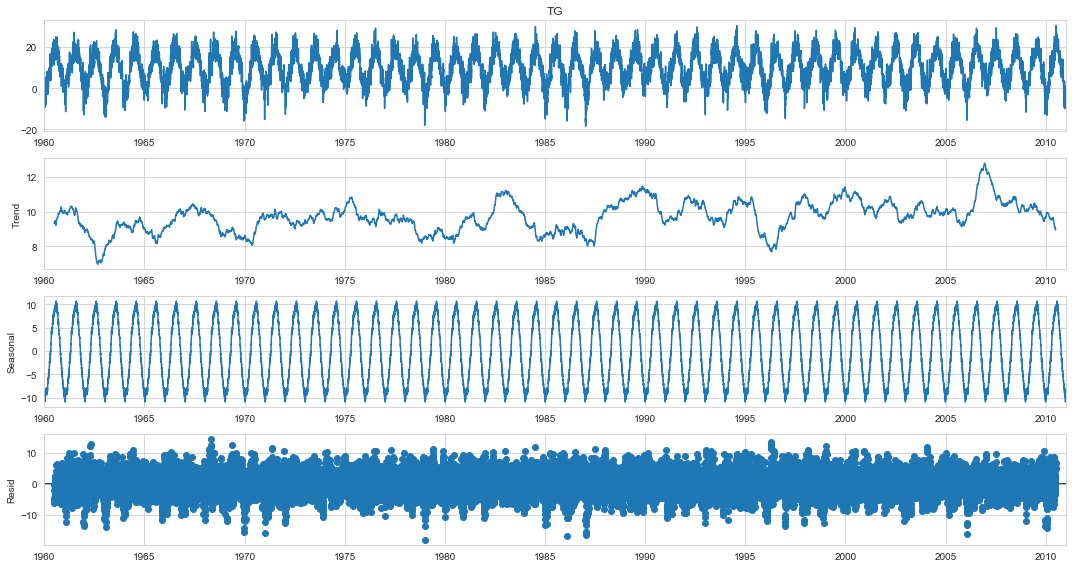

In [32]:
sd = seasonal_decompose(df_train['TG'], period = 365)
sd.plot()
None

In [33]:
 ## Model the seasonality in sklearn

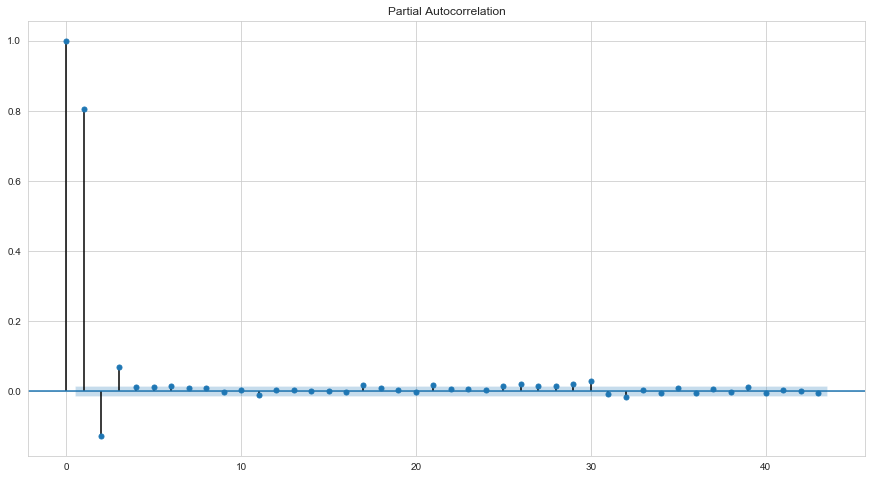

In [34]:
#Create 'month' column for model the seasonality
df_train['month'] = df_train.index.month
#use one hot encoding method by get_dummies function
seasonal_dummies = pd.get_dummies(df_train['month'], prefix='month_')
#Join the dummies to original train dataframe
df_train = df_train.join(seasonal_dummies)
X_train = df_train.drop(['month', 'TG'], axis=1)
y_train = df_train['TG']
m = LinearRegression()
m.fit(X_train, y_train)
df_train['trend_and_seasonality'] = m.predict(X_train)
df_train['remainder'] = df_train['TG'] - df_train['trend_and_seasonality']
plot_pacf(df_train['remainder']); 
#df_train.head()

In [35]:
## Train the Autoregressive Model (AR)

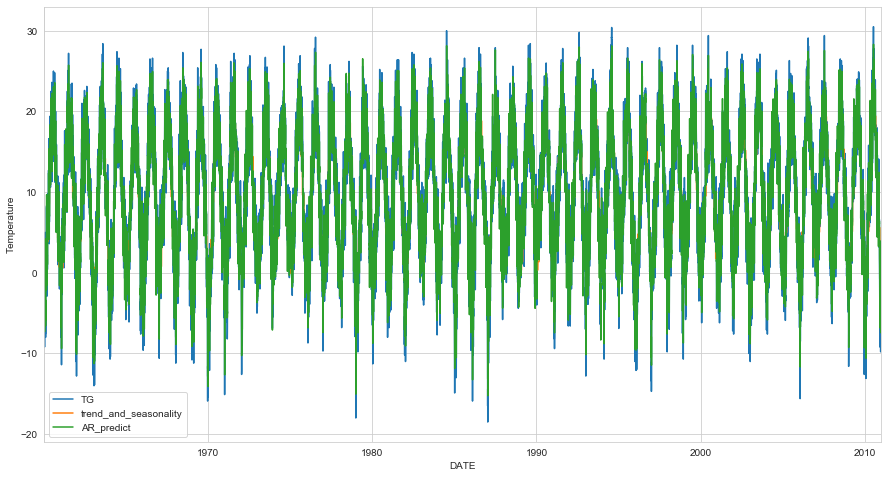

In [38]:
# Create 3 lags in the df_train dataframe as we noticed from pacf plot.
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)
df_train.dropna(inplace=True)
X_AR_train = df_train.drop(columns=['TG', 'trend_and_seasonality', 'remainder'])
y_AR_train = df_train['TG']

#Define X and Y for AR Model and fit the model 
m_AR = LinearRegression()
m_AR.fit(X_AR_train, y_AR_train)

# Make predictions based on AR model 
df_train['AR_predict'] = m_AR.predict(X_AR_train)

# Plot the original TG, Trend and seasonality and AR predictions.
df_train[['TG', 'trend_and_seasonality', 'AR_predict']].plot()
plt.ylabel('Temperature');

In [39]:
## Evaluation of the Model by cross validation

In [42]:
ts_split = TimeSeriesSplit(n_splits=5)
# Create the time series split
time_series_split = ts_split.split(X_AR_train, y_AR_train)
# Apply crossmvalidation model
result = cross_val_score(estimator=m_AR, X=X_AR_train, y=y_AR_train, cv=time_series_split)
# Scores are R-sqaured Matrix(default for Linear Regression in scikitlearn)
print(f'The cross validation score of the AR model is {round(result.mean(), 2)}.')

The cross validation score of the AR model is 0.91.


In [ ]:
## Apply all Feature enginnering on test data whatever we have done on train data

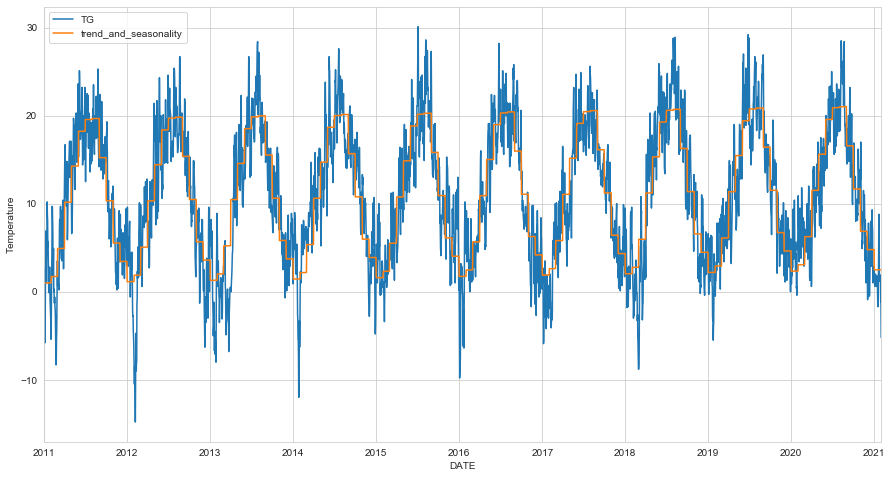

In [43]:
df_test['timestep'] = range(len(df_test))
X = df_test[['timestep']]
y = df_test['TG']
m = LinearRegression()
m.fit(X,y)
df_test['Trend'] = m.predict(X)
#df_test[['TG', 'Trend']].plot();
#Create 'month' column for model the seasonality
df_test['month'] = df_test.index.month
#use one hot encoding method by get_dummies function
seasonal_dummies = pd.get_dummies(df_test['month'], prefix='month_')
#Join the dummies to original train dataframe
df_test = df_test.join(seasonal_dummies)
X_test = df_test.drop(['month', 'TG'], axis=1)
y_test = df_test['TG']
m = LinearRegression()
m.fit(X_test, y_test)
df_test['trend_and_seasonality'] = m.predict(X_test)
df_test['remainder'] = df_test['TG'] - df_test['trend_and_seasonality']
#plot_pacf(df_test['remainder']); 
#df_train.head()
df_test[['TG', 'trend_and_seasonality']].plot()
plt.ylabel('Temperature');

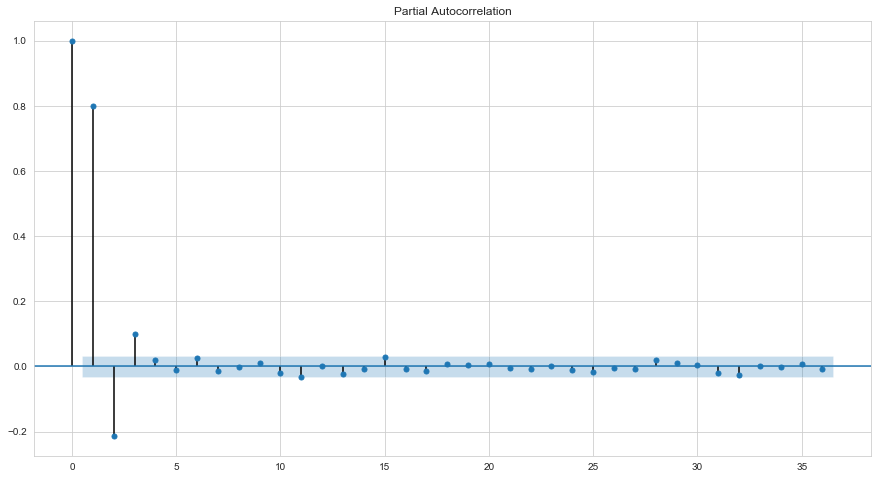

In [44]:
plot_pacf(df_test['remainder']); 

In [ ]:
## Train AR model on test data

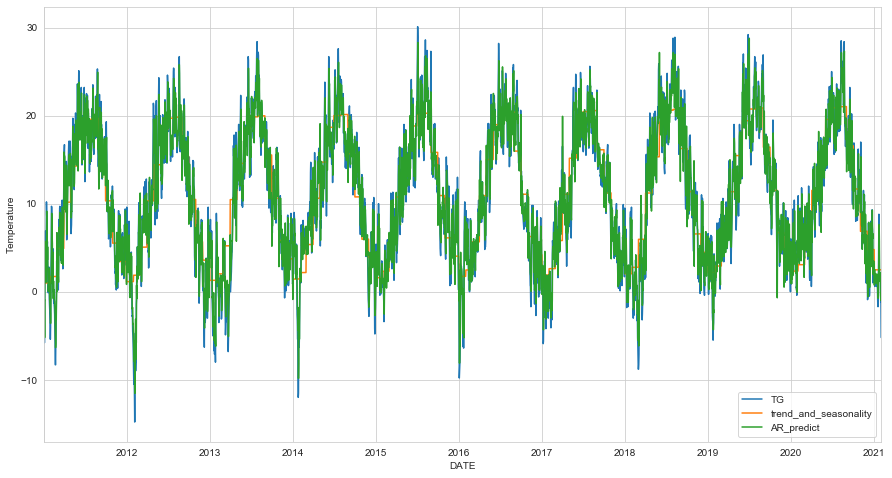

In [45]:
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test.dropna(inplace=True)
X_AR_test = df_test.drop(columns=['TG', 'trend_and_seasonality', 'remainder'])
y_AR_test = df_test['TG']

#Define X and Y for AR Model and fit the model 
m_AR = LinearRegression()
m_AR.fit(X_AR_test, y_AR_test)

# Make predictions based on AR model 
df_test['AR_predict'] = m_AR.predict(X_AR_test)

# Plot the original TG, Trend and seasonality and AR predictions.
df_test[['TG', 'trend_and_seasonality', 'AR_predict']].plot()
plt.ylabel('Temperature');

In [ ]:
## Future Prediction based on our trained model

In [46]:
# combine all train and test data
df_full = df_train.append(df_test)
X_full = df_full.drop(columns=['TG','trend_and_seasonality','AR_predict','month','Trend','remainder','month__1'])
y_full = df_full['TG']
# Create and fit the ts model (trend-seasonal model)
m_full = LinearRegression()
m_full.fit(X_full, y_full)

# Create a new column with the predictions of the trend_seasonal model
df_full['prediction_full'] = m_full.predict(X_full)
m_full.score(X_full, y_full)
#X_full.head()

0.9073452188209524

In [47]:
# What is the first date in the future? --> 1961-01-01
timestep = df_full['timestep'].max() + 1
months =[0] * 11  # because it is January, which is the first dummy-feature (which we dropped)
months

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
lag1 = df_full.loc['2021-01-31', 'TG']
lag2 = df_full.loc['2021-01-30', 'TG']
lag3 = df_full.loc['2021-01-29', 'TG']

In [49]:
df_full.tail()

,TG,timestep,Trend,month,month__1,month__2,month__3,month__4,month__5,month__6,...,month__10,month__11,month__12,trend_and_seasonality,remainder,lag1,lag2,lag3,AR_predict,prediction_full
DATE,,,,,,,,,,,,,,,,,,,,,
2021-01-27,1.9,3679,11.766631,1,1,0,0,0,0,0,...,0,0,0,2.491964,-0.591964,-1.291556,-1.091148,-1.290739,1.390901,-0.592215
2021-01-28,1.6,3680,11.767060,1,1,0,0,0,0,0,...,0,0,0,2.492373,-0.892373,-0.591964,-1.291556,-1.091148,2.169820,0.113310
2021-01-29,-1.2,3681,11.767489,1,1,0,0,0,0,0,...,0,0,0,2.492781,-3.692781,-0.892373,-0.591964,-1.291556,1.633204,-0.326259
2021-01-30,-1.2,3682,11.767918,1,1,0,0,0,0,0,...,0,0,0,2.493189,-3.693189,-3.692781,-0.892373,-0.591964,-0.989234,-2.810123
2021-01-31,-5.2,3683,11.768347,1,1,0,0,0,0,0,...,0,0,0,2.493598,-7.693598,-3.693189,-3.692781,-0.892373,-0.146276,-2.247236


In [50]:
X_future = []
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future = pd.DataFrame([X_future], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1','lag2','lag3'])
X_future.rename(index={0:pd.to_datetime("2021-02-01 00:00:00")},inplace=True)
X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
2021-02-01,18628,0,0,0,0,0,0,0,0,0,0,0,-5.2,-1.2,-1.2


In [51]:
m_full.predict(X_future)

array([-4.0229056])

In [52]:
arima_model = ARIMA(df_train['remainder'], order=(3,0,0)).fit()

C:\Users\DELL PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\DELL PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\DELL PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [53]:
arima_model